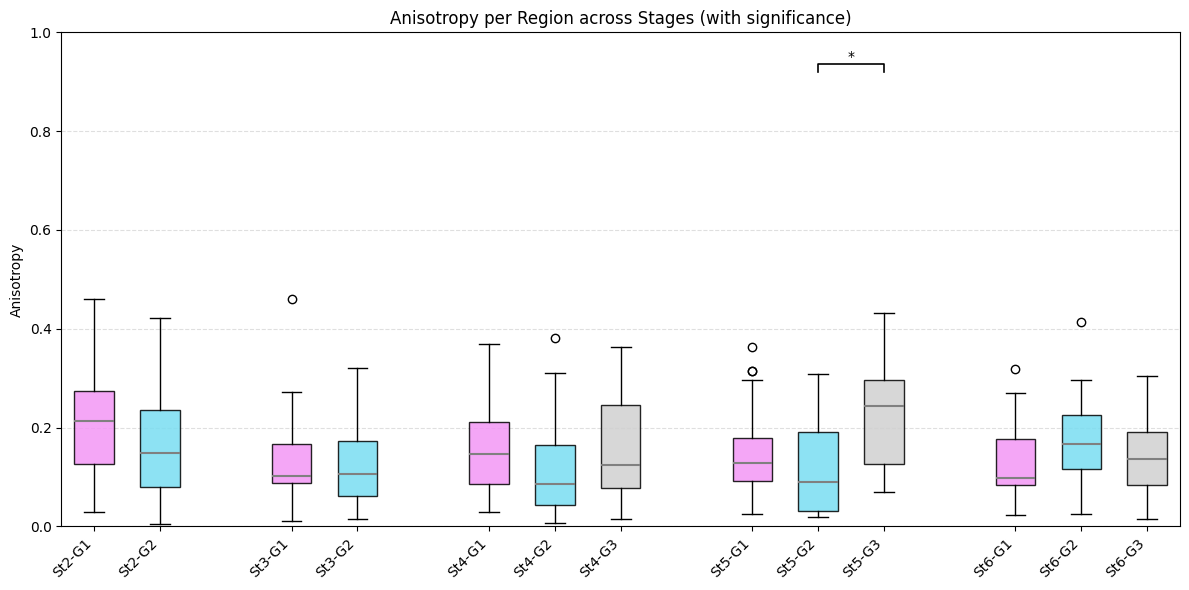

Stage 2 — Kruskal-Wallis H=2.933, p=0.08679
Stage 3 — Kruskal-Wallis H=0.000, p=0.9883
Stage 4 — Kruskal-Wallis H=6.531, p=0.03819
  G1 vs G2: raw p=0.02262
  G1 vs G3: raw p=0.8292
  G2 vs G3: raw p=0.03386
  G1 vs G2: Bonferroni p=0.06785 (ns)
  G1 vs G3: Bonferroni p=1 (ns)
  G2 vs G3: Bonferroni p=0.1016 (ns)
Stage 5 — Kruskal-Wallis H=9.381, p=0.009181
  G1 vs G2: raw p=0.1767
  G1 vs G3: raw p=0.01739
  G2 vs G3: raw p=0.007234
  G1 vs G2: Bonferroni p=0.5302 (ns)
  G1 vs G3: Bonferroni p=0.05216 (ns)
  G2 vs G3: Bonferroni p=0.0217 (*)
Stage 6 — Kruskal-Wallis H=2.976, p=0.2258

Statistical results have also been saved to 'statistical_results_log.txt'


In [ ]:
#this code was written with the help of ChatGPT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations

# === Load your data ===
df = pd.read_excel("data_redone_after_reordering_and_verification.xlsx")

XCOL, YCOL, ANICOL, STAGECOL = "box cor X", "box cor Y", "anisotropy", "stage"

# === Region definitions ===
regions_by_stage = {
    2: [("G1", 0.00, 0.45, 0.00, 0.50),
        ("G2", 0.45, 1.00, 0.00, 0.50)],
    3: [("G1", 0.00, 0.45, 0.00, 0.50),
        ("G2", 0.45, 1.00, 0.00, 0.50)],
    4: [("G1", 0.00, 0.55, 0.00, 0.25),
        ("G2", 0.55, 1.00, 0.00, 0.25),
        ("G3", 0.00, 1.00, 0.25, 0.50)],
    5: [("G1", 0.00, 0.65, 0.00, 0.25),
        ("G2", 0.65, 1.00, 0.00, 0.25),
        ("G3", 0.00, 1.00, 0.25, 0.50)],
    6: [("G1", 0.00, 0.65, 0.00, 0.25),
        ("G2", 0.65, 1.00, 0.00, 0.25),
        ("G3", 0.00, 1.00, 0.25, 0.50)],
}

# === Assign points to regions ===
rows = []
for stage, regs in regions_by_stage.items():
    sdf = df[df[STAGECOL] == stage]
    for _, r in sdf.iterrows():
        x, y = r[XCOL], r[YCOL]
        for name, xmin, xmax, ymin, ymax in regs:
            if xmin <= x <= xmax and ymin <= y <= ymax:
                rows.append({"stage": stage, "region": name, "anisotropy": r[ANICOL]})

long_df = pd.DataFrame(rows)

# === Helper functions ===
def stars(p):
    if p >= 0.05:
        return "ns"
    elif p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    else:
        return "*"

def add_sig_bar(ax, x1, x2, y, text, h=0.015, lw=1.2):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], color='k', lw=lw, clip_on=False)
    ax.text((x1 + x2) / 2, y + h, text, ha='center', va='bottom', fontsize=10)

# === Manual Bonferroni correction ===
def bonferroni_correction(p_values):
    m = len(p_values)
    return [min(p*m, 1.0) for p in p_values]

# === Plot setup ===
plt.figure(figsize=(12, 6))
ax = plt.gca()
color_map = {"G1": "#f397f5", "G2": "#79ddf1", "G3": "#d0d0d0"}

labels = []
data = []
colors = []
positions = []
label_to_pos = {}
pos = 1

# Build plot data
for stage in [2, 3, 4, 5, 6]:
    region_order = [r[0] for r in regions_by_stage[stage]]
    for reg_name in region_order:
        sub = long_df[(long_df["stage"] == stage) & (long_df["region"] == reg_name)]
        if not sub.empty:
            labels.append(f"St{stage}-{reg_name}")
            data.append(sub["anisotropy"].values)
            colors.append(color_map[reg_name])
            positions.append(pos)
            label_to_pos[(stage, reg_name)] = pos
            pos += 1
    pos += 1  # gap

bp = ax.boxplot(data, positions=positions, patch_artist=True, widths=0.6)
for patch, col in zip(bp['boxes'], colors):
    patch.set_facecolor(col)
    patch.set_alpha(0.85)
    
for median in bp['medians']:
    median.set_color('gray')
    median.set_linewidth(1.5)  # optional: makes it thicker


ax.set_ylim(0, 1)
ax.set_ylabel("Anisotropy")
ax.set_title("Anisotropy per Region across Stages (with significance)")
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

# === Significance tests & logging ===
log_lines = []
y_top = 0.92
stage_gap = 0.06

for stage in [2, 3, 4, 5, 6]:
    sub = long_df[long_df["stage"] == stage]
    if sub.empty:
        continue
    regs_present = [r[0] for r in regions_by_stage[stage] if not sub[sub["region"] == r[0]].empty]
    if len(regs_present) < 2:
        continue

    groups = [sub[sub["region"] == r]["anisotropy"].values for r in regs_present]
    kw_stat, kw_p = kruskal(*groups)
    log_lines.append(f"Stage {stage} — Kruskal-Wallis H={kw_stat:.3f}, p={kw_p:.4g}")

    if kw_p < 0.05:
        pairs = list(combinations(regs_present, 2))
        raw_p = []
        for a, b in pairs:
            x = sub[sub["region"] == a]["anisotropy"].values
            y = sub[sub["region"] == b]["anisotropy"].values
            stat, p = mannwhitneyu(x, y, alternative="two-sided")
            raw_p.append(p)
            log_lines.append(f"  {a} vs {b}: raw p={p:.4g}")

        adj_p = bonferroni_correction(raw_p)
        for (a, b), p_adj in zip(pairs, adj_p):
            sig_label = stars(p_adj)
            log_lines.append(f"  {a} vs {b}: Bonferroni p={p_adj:.4g} ({sig_label})")
            if p_adj < 0.05:
                x1 = label_to_pos[(stage, a)]
                x2 = label_to_pos[(stage, b)]
                add_sig_bar(ax, x1, x2, y_top, sig_label)
                y_top += stage_gap

# Save the statistical log to a text file
with open("statistical_results_log.txt", "w") as f:
    f.write("\n".join(log_lines))

plt.tight_layout()
plt.show()

print("\n".join(log_lines))
print("\nStatistical results have also been saved to 'statistical_results_log.txt'")
